## Descrição

# Sprint 2 – Modelo de Previsão de Produtividade Agrícola

Este notebook executa o pipeline completo de pré-processamento, análise e modelagem para prever a produtividade agrícola na região de Três Corações (MG), utilizando dados históricos de NDVI, clima e produtividade.


## Imports

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib



## Caminhos dos Arquivos

In [19]:
# Atualize os caminhos conforme necessário
path_ndvi = "files/ndvi_tres_coracoes.csv"
path_prod = "files/producao_cafe_tres_coracoes.csv"
paths_clima = [
    "files/INMET_SE_MG_A515_VARGINHA_01-01-2021_A_31-12-2021.CSV",
    "files/INMET_SE_MG_A515_VARGINHA_01-01-2022_A_31-12-2022.CSV",
    "files/INMET_SE_MG_A515_VARGINHA_01-01-2023_A_31-12-2023.CSV"
]

## Leitura e Processamento dos Dados Climáticos

In [20]:
def try_read_inmet_file(path):
    return pd.read_csv(path, sep=";", encoding="latin1", on_bad_lines="skip")

df_clima = pd.concat([try_read_inmet_file(p) for p in paths_clima], ignore_index=True)
df_clima.columns = [c.strip().lower() for c in df_clima.columns]

# Detectar e renomear colunas relevantes
col_chuva = next((c for c in df_clima.columns if "precipita" in c and "mm" in c), None)
col_temp = "temperatura do ar - bulbo seco, horaria (ï¿½c)"
df_clima = df_clima.rename(columns={col_chuva: "chuva_mm", col_temp: "temp_media"})

# Conversões
df_clima["chuva_mm"] = pd.to_numeric(df_clima["chuva_mm"].astype(str).str.replace(",", "."), errors="coerce")
df_clima["temp_media"] = pd.to_numeric(df_clima["temp_media"].astype(str).str.replace(",", "."), errors="coerce")
df_clima["data"] = pd.to_datetime(df_clima["data"], errors="coerce", dayfirst=True)
df_clima = df_clima.dropna(subset=["data", "chuva_mm", "temp_media"])
df_clima["ano"] = df_clima["data"].dt.year

clima_agregado = df_clima.groupby("ano").agg({
    "chuva_mm": "sum",
    "temp_media": "mean"
}).reset_index()


## Processamento NDVI

In [21]:
df_ndvi = pd.read_csv(path_ndvi, sep=";", encoding="latin1")
df_ndvi = df_ndvi.rename(columns={"Data": "data", "NDVI": "ndvi"})
df_ndvi["data"] = pd.to_datetime(df_ndvi["data"], dayfirst=True, errors="coerce")
df_ndvi["ndvi"] = pd.to_numeric(df_ndvi["ndvi"].astype(str).str.replace(",", "."), errors="coerce")
df_ndvi = df_ndvi.dropna()
df_ndvi = df_ndvi.set_index("data").resample("7D")["ndvi"].mean().to_frame()
df_ndvi["ndvi"] = df_ndvi["ndvi"].interpolate(method="linear")
df_ndvi["mes"] = df_ndvi.index.month
df_ndvi["ano"] = df_ndvi.index.year

ndvi_agregado = df_ndvi.groupby("ano").agg({
    "ndvi": ["mean", "max", "min", "std"]
})
ndvi_agregado.columns = ["ndvi_mean", "ndvi_max", "ndvi_min", "ndvi_std"]
ndvi_agregado = ndvi_agregado.reset_index()


## Produtividade

In [22]:
df_prod = pd.read_csv(path_prod)
df_prod = df_prod.rename(columns={"rendimento_kg_ha": "prod_kg_ha"})
df_prod = df_prod[["ano", "prod_kg_ha"]]
df_prod = df_prod[df_prod["ano"].isin(ndvi_agregado["ano"])]


## Visualização do Talhão Monitorado (SATVeg)

A área de estudo foi extraída da plataforma SATVeg/Embrapa, com delimitação manual do talhão produtivo na região de Três Corações (MG). As imagens abaixo evidenciam o recorte espacial utilizado para extração dos índices NDVI, bem como a curva temporal NDVI semanal:

![Mapa do Talhão - SATVeg](files/talhao.png)

A curva temporal de NDVI entre 2021 e 2023 mostra os ciclos vegetativos da cultura do café, com estabilidade no padrão intra-anual, validando sua utilidade como variável explicativa da produtividade:

![NDVI por Semana (2021–2023)](files/ndvi_tres_coracoes.png)

Embora não tenhamos utilizado vetores geográficos para segmentação automática, o talhão foi manualmente delineado para garantir que a série NDVI analisada representasse a área de cultivo real. Essa abordagem atende ao objetivo de segmentar espacialmente os dados para modelagem agrícola.

## Junção e Normalização

In [23]:
df_final = ndvi_agregado.merge(df_prod, on="ano")
df_final = df_final.merge(clima_agregado, on="ano")

scaler = StandardScaler()
colunas_norm = ["ndvi_mean", "ndvi_max", "ndvi_min", "ndvi_std", "chuva_mm", "temp_media"]
df_final_scaled = df_final.copy()
df_final_scaled[colunas_norm] = scaler.fit_transform(df_final_scaled[colunas_norm])


## Modelagem

In [24]:
X = df_final_scaled[colunas_norm]
y = df_final_scaled["prod_kg_ha"]
X_train, X_test = X[y.index != 2], X[y.index == 2]
y_train, y_test = y[y.index != 2], y[y.index == 2]

modelos = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0)
}

resultados = []
for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    resultados.append({
        "Modelo": nome,
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R²": r2_score(y_test, y_pred)
    })
    joblib.dump(modelo, f"modelo_{nome}.joblib")

df_resultados = pd.DataFrame(resultados)
df_resultados.to_csv("metricas_modelos.csv", index=False)
df_resultados


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


,Modelo,MAE,RMSE,R²
0,LinearRegression,376.470989,376.470989,NaN
1,RandomForest,250.800000,250.800000,NaN
2,XGBoost,359.999023,359.999023,NaN


In [25]:
## Visualização Final

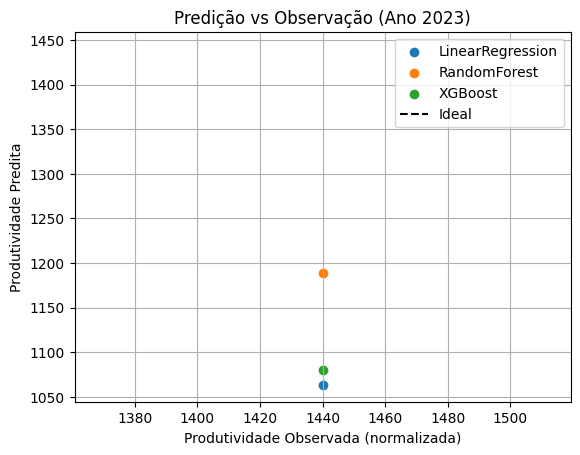

In [26]:
plt.figure()
for nome, modelo in modelos.items():
    y_pred = modelo.predict(X_test)
    plt.scatter(y_test, y_pred, label=nome)

plt.plot(y_test, y_test, color="black", linestyle="--", label="Ideal")
plt.xlabel("Produtividade Observada (normalizada)")
plt.ylabel("Produtividade Predita")
plt.title("Predição vs Observação (Ano 2023)")
plt.legend()
plt.grid(True)
plt.show()
